In [1]:
# download from google drive or upload file by yourself
!pip install --upgrade gdown==v4.6.3
!gdown --fuzzy '1jXEzNJr7iYJzhzl7695_0scTqJB0_5L7' --output retina-dataset.zip
!unzip -q retina-dataset.zip

  Attempting uninstall: gdown
    Found existing installation: gdown 5.2.0
    Uninstalling gdown-5.2.0:
      Successfully uninstalled gdown-5.2.0
Downloading...
From: https://drive.google.com/uc?id=1jXEzNJr7iYJzhzl7695_0scTqJB0_5L7
To: /content/retina-dataset.zip
100% 622M/622M [00:07<00:00, 87.1MB/s]


In [2]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
from glob import glob
from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split
import pandas as pd


In [3]:
# Define Parameters
NUM_CLASS = 5
IMG_SIZE = 224
BS = 64
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

#### Data Visualization



In [4]:
df = pd.read_csv("kaggle_retina/train.csv")
df.head()

,id_code,diagnosis
0,c1e6fa1ad314,1
1,ed246ae1ed08,4
2,4d3de40ced3a,0
3,ae8472f8d310,1
4,3c28fd846b43,0


In [5]:
paths = glob('kaggle_retina/train/*.png')
paths_test = sorted(glob('kaggle_retina/test/*.png'))
len(paths), len(paths_test)

(2197, 1465)

kaggle_retina/train/0ada12c0e78f.png
label: 4


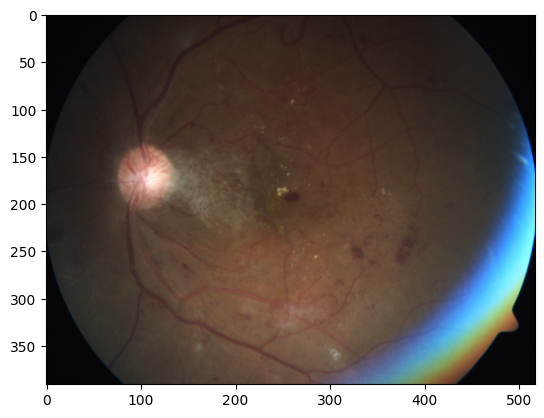

In [6]:
idx = np.random.randint(0, len(df))
row = df.iloc[idx]
filename = row["id_code"]
path = f"kaggle_retina/train/{filename}.png"
img = Image.open(path)
plt.imshow(img)
print(path)
print(f'label: {row["diagnosis"]}')

In [7]:
all_cls = df['diagnosis'].tolist()
print(all_cls[:3])

[1, 4, 0]


<BarContainer object of 5 artists>

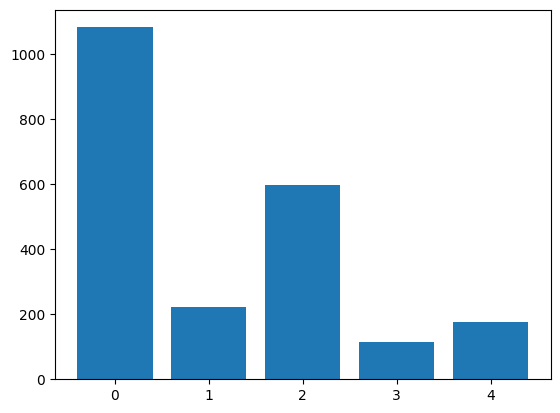

In [8]:
# Class distribution
cls, count = np.unique(all_cls, return_counts=True)
plt.bar(cls, count)

#### Dataset, DataLoader

In [9]:
class RetinaDataset(torch.utils.data.Dataset):
    def __init__(self, df, transform):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        filename = row["id_code"]
        path = f"kaggle_retina/train/{filename}.png"
        img = Image.open(path)
        img = self.transform(img)

        label = row["diagnosis"]
        label = torch.tensor(label, dtype=torch.long)

        return img, label

In [10]:
df = pd.read_csv("kaggle_retina/train.csv")
train_df, val_df = train_test_split(df,
                                    test_size=0.2,
                                    random_state=5566)

Use image transform from pretrained model

In [11]:
import torchvision
transform = torchvision.models.ResNet50_Weights.DEFAULT.transforms()  #ResNet50_Weights

In [12]:
train_ds = RetinaDataset(train_df, transform)
val_ds = RetinaDataset(val_df, transform)

622 tensor(2)
(224, 224, 3)


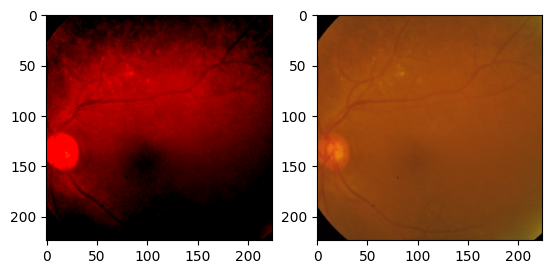

In [13]:
idx = np.random.randint(0, len(train_ds))
img, label = train_ds[idx]
print(idx, label)
plt.subplot(1, 2, 1)
plt.imshow(img.permute(1, 2, 0))

# Convert back to original value
img_raw = img.numpy().transpose(1, 2, 0) # (3, 256, 256) -> (256, 256, 3)
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
img_raw = std * img_raw + mean
img_raw = np.clip(img_raw, 0, 1)
print(img_raw.shape)
plt.subplot(1, 2, 2)
plt.imshow(img_raw)
plt.show()

In [14]:
train_loader = torch.utils.data.DataLoader(train_ds, BS, shuffle=True,
                                           pin_memory=True)
val_loader = torch.utils.data.DataLoader(val_ds, BS,
                                         pin_memory=True)

#### Model

Pick your favorite models: https://pytorch.org/vision/stable/models.html

In [15]:
from torchvision import models, transforms
from torchvision.models import resnet50, ResNet50_Weights

In [16]:
def build_model(num_classes, freeze=True):

    # 1. 載入預訓練的基礎模型
    # 使用最新的預訓練權重 (Weights.IMAGENET1K_V2)
    model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)

# 2. 凍結/解凍基礎模型的權重
    if freeze:
        # 凍結所有基礎模型的參數
        #for param in model.parameters():
           # param.requires_grad = False #關掉梯度需求
        # 凍結模型的layer1模組
        for param in model.layer1.parameters():
            param.requires_grad = False

    # 3. 構建新的頂部分類層 (將特徵映射到新類別)
    # ResNet 的分類層是名為 'fc' 的全連接層
    num_ftrs = model.fc.in_features

    model.fc = nn.Sequential(nn.Dropout(0.2), nn.Linear(num_ftrs, num_classes))
        # nn.Linear(num_ftrs, num_classes)

    return model

In [17]:
# Mock inputs
inputs = torch.randn(1, 3, 224, 224).to(device)
model = build_model(num_classes=NUM_CLASS, freeze=False).to(device)
outputs = model(inputs)
outputs.shape

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 186MB/s]


torch.Size([1, 5])

#### Training

In [18]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

In [19]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset) # number of samples
    num_batches = len(dataloader) # batches per epoch

    model.train() # to training mode.
    epoch_loss, epoch_correct = 0, 0
    for batch_i, (x, y) in enumerate(tqdm(dataloader, leave=False)):
        x, y = x.to(device), y.to(device) # move data to GPU

        # zero the parameter gradients
        optimizer.zero_grad()

        # Compute prediction loss
        pred = model(x)
        loss = loss_fn(pred, y)

        # Optimization by gradients
        loss.backward() # backpropagation to compute gradients
        optimizer.step() # update model params

        # write to logs
        epoch_loss += loss.item() # tensor -> python value
        # (N, Class)
        epoch_correct += (pred.argmax(dim=1) == y).sum().item()

    # return avg loss of epoch, acc of epoch
    return epoch_loss/num_batches, epoch_correct/size


def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset) # number of samples
    num_batches = len(dataloader) # batches per epoch

    model.eval() # model to test mode.
    epoch_loss, epoch_correct = 0, 0

    # No gradient for test data
    with torch.no_grad():
        for batch_i, (x, y) in enumerate(dataloader):
            x, y = x.to(device), y.to(device)

            # Compute prediction loss
            pred = model(x)
            loss = loss_fn(pred, y)

            # write to logs
            epoch_loss += loss.item()
            epoch_correct += (pred.argmax(1) == y).sum().item()

    return epoch_loss/num_batches, epoch_correct/size

In [20]:
EPOCHS = 100
logs = {
    'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []
}
# Earlystopping
patience = 5
counter = 0
best_loss = np.inf

for epoch in tqdm(range(EPOCHS)):
    train_loss, train_acc = train(train_loader, model, loss_fn, optimizer)
    val_loss, val_acc = test(val_loader, model, loss_fn)

    print(f'EPOCH: {epoch:04d} \
    train_loss: {train_loss:.4f}, train_acc: {train_acc:.3f} \
    val_loss: {val_loss:.4f}, val_acc: {val_acc:.3f} ')

    logs['train_loss'].append(train_loss)
    logs['train_acc'].append(train_acc)
    logs['val_loss'].append(val_loss)
    logs['val_acc'].append(val_acc)

    torch.save(model.state_dict(), "last.pth")
    # chcek improvement
    if val_loss < best_loss:
        counter = 0
        best_loss = val_loss
        torch.save(model.state_dict(), "best.pth")
    else:
        counter += 1
    if counter >= patience:
        print("Earlystop!")
        break

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH: 0000     train_loss: 0.8184, train_acc: 0.711     val_loss: 0.7083, val_acc: 0.732 


  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH: 0001     train_loss: 0.5467, train_acc: 0.796     val_loss: 0.8020, val_acc: 0.714 


  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH: 0002     train_loss: 0.4514, train_acc: 0.825     val_loss: 0.7563, val_acc: 0.786 


  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH: 0003     train_loss: 0.3668, train_acc: 0.859     val_loss: 0.5228, val_acc: 0.809 


  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH: 0004     train_loss: 0.2454, train_acc: 0.916     val_loss: 0.6324, val_acc: 0.802 


  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH: 0005     train_loss: 0.1609, train_acc: 0.941     val_loss: 0.7851, val_acc: 0.800 


  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH: 0006     train_loss: 0.1451, train_acc: 0.949     val_loss: 0.8427, val_acc: 0.807 


  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH: 0007     train_loss: 0.1606, train_acc: 0.945     val_loss: 0.6709, val_acc: 0.780 


  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH: 0008     train_loss: 0.1625, train_acc: 0.944     val_loss: 1.2663, val_acc: 0.734 
Earlystop!


#### Kaggle Submission

https://www.kaggle.com/competitions/diabetic-retinopathy-classification-3/overview

In [21]:
model.load_state_dict(torch.load('best.pth'))
_ = model.eval().to(device)

In [22]:
class TestDataset(torch.utils.data.Dataset):
    def __init__(self, df, transform):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        filename = row["id_code"]
        path = f"kaggle_retina/test/{filename}.png"
        img = Image.open(path)
        img = self.transform(img)
        return img

df = pd.read_csv('kaggle_retina/submission.csv')
test_ds = TestDataset(df, transform)
test_loader = torch.utils.data.DataLoader(test_ds, BS)

In [23]:
# Inference
y_pred = []
with torch.no_grad():
    for x in tqdm(test_loader):
        x = x.to(device)
        pred = model(x)
        y_pred.append(pred.argmax(dim=1))

y_pred = torch.cat(y_pred, dim=0).cpu().numpy()

  0%|          | 0/23 [00:00<?, ?it/s]

In [24]:
df['diagnosis'] = y_pred
df.to_csv('submission.csv', index=None)

####Log

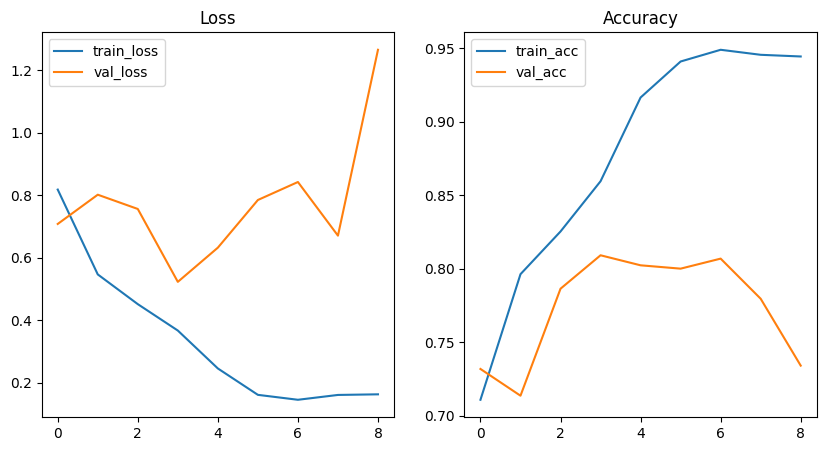

In [25]:
# Plot loss curve
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('Loss')
plt.plot(logs['train_loss'])
plt.plot(logs['val_loss'])
plt.legend(['train_loss', 'val_loss'])
# plot acc
plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.plot(logs['train_acc'])
plt.plot(logs['val_acc'])
plt.legend(['train_acc', 'val_acc'])
plt.show()

#### Evaluation

In [30]:
# 將模型移到 GPU 或 CPU（依照 device 設定）
model = model.to(device)

# 切換到評估模式 (evaluation mode)
# - 關閉 Dropout
# - 使用 BatchNorm 的移動平均 (running stats)
model.eval()

# 建立暫存 tensor，用來收集所有 Ground truth 與模型輸出
y_true = torch.tensor([], dtype=torch.long).to(device)   # 真實標籤
y_pred_logits = torch.tensor([]).to(device)             # 模型輸出 (logits)

# 關閉梯度計算 (減少記憶體使用、加快推論速度)
with torch.no_grad():
    for x, y in val_loader:          # 從驗證集 DataLoader 逐批讀取資料
        x, y = x.to(device), y.to(device)  # 移到 GPU/CPU

        pred = model(x)              # 前向傳播得到 logits

        # 將目前 batch 的結果拼接到總體結果上
        y_true = torch.cat((y_true, y), dim=0)
        y_pred_logits = torch.cat((y_pred_logits, pred), dim=0)

# 從 logits 取出預測類別 (取最大值索引)
# 例如 (100, 3) → (100,) 代表 100 筆樣本，每筆選出 1 類別
y_pred_cls = y_pred_logits.argmax(1)

# 將 logits 轉換成機率分布 (Softmax)
y_pred_probs = torch.nn.functional.softmax(y_pred_logits, dim=1)

# 將 Tensor 移回 CPU 並轉成 numpy.ndarray，方便後續做評估 (e.g. sklearn.metrics)
y_true = y_true.cpu().numpy()
y_pred_cls = y_pred_cls.cpu().numpy()
y_pred_probs = y_pred_probs.cpu().numpy()

# 計算 ACC.
acc = sum(y_true == y_pred_cls) / len(y_true)

In [31]:
from sklearn.metrics import confusion_matrix, recall_score, roc_auc_score

# A. 計算混淆矩陣 (Confusion Matrix)
cm = confusion_matrix(y_true, y_pred_cls)
print("混淆矩陣:\n", cm)

# B. 計算敏感度 (Sensitivity)
sensitivity = recall_score(y_true, y_pred_cls, average='weighted')
print(f"敏感度 (Sensitivity - Weighted): {sensitivity * 100:.2f}%")

# C. 計算 AUC (Area Under ROC Curve)
auc_score = roc_auc_score(y_true, y_pred_probs, multi_class='ovr')
print(f"AUC Score: {auc_score:.4f}")

混淆矩陣:
 [[226   4   0   0   0]
 [  6  20  13   0   2]
 [  4   8  87   3   8]
 [  1   0   9   9   6]
 [  0   3  15   2  14]]
敏感度 (Sensitivity - Weighted): 80.91%
AUC Score: 0.9347
